In [0]:
from time import time
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import scipy.io as sio
import scipy.spatial.distance as ssd
from scipy.stats import chisquare
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import cv2

In [0]:
from google.colab import drive
drive.mount('/content/drive')
data = "/content/drive/My Drive/Colab Notebooks/face.mat"

In [0]:
faces = sio.loadmat(data)
X, y = [], []
for i in range(53):
  face_i = faces['X'][:, 10*i:10*(i+1)]
  label_i = faces['l'][:, 10*i:10*(i+1)]
  X.append(face_i.T)
  y.append(label_i.T)
X = np.concatenate(X)
X = np.array(X)
y = np.concatenate(y)
y = np.concatenate(y)

In [0]:
X_train, X_test, y_train, y_test = [], [], [], []
# train
for i in range(32):
    face_i = faces['X'][:, 10*i:10*(i+1)]
    label_i = faces['l'][:, 10*i:10*(i+1)]
  
    X_train.append(face_i.T)
    y_train.append(label_i.T)
#  test
for i in range(32, 53):
    face_i = faces['X'][:, 10*i:10*(i+1)]
    label_i = faces['l'][:, 10*i:10*(i+1)]
    X_test.append(face_i.T)
    y_test.append(label_i.T) 

In [0]:
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)
y_train = np.concatenate(y_train)
y_test = np.concatenate(y_test)

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [0]:
X_train_N = normalize(X_train, axis=1, norm='l2')
X_test_N = normalize(X_test, axis=1, norm='l2')

In [0]:
# ranks and mAP
from collections import defaultdict

def calculateRank(matrix, y=y_test):
  rank1, rank10 = 0, 0
  for img, label in zip(matrix, y):
    for i in range(1, 11):
      _, predicted = img[i]
      if predicted == label[0]:
        rank1 = rank1 + 1 if i == 1 else rank1
        rank10 += 1
        break
  rank1_pc = rank1/200*100
  rank10_pc = rank10/200*100
  return rank1_pc, rank10_pc

def calculateMAP(matrix, y=y_test):
  mAP = []
  for img, label in zip(matrix, y):
    rank = defaultdict(list)
    total_correct = 0
    for i in range(11):
      _, predicted = img[i]
      total_correct = total_correct + 1 if predicted == label[0] else total_correct
      precision = total_correct/(i+1)
      rank[i+1].append(precision)
    new_correct = 0
    for i in range(11):
      _, predicted = img[i]
      new_correct = new_correct + 1 if predicted == label[0] else new_correct
      recall = new_correct/total_correct if total_correct != 0 else 0
      rank[i+1].append(recall)
    mAP.append(rank)
  return mAP

def numericalMAP(matrix):
  AP = 0
  for d in matrix:
    vals = np.array(list(d.values()))
    AP += np.trapz(vals.T[0], vals.T[1])
  return AP/len(matrix)

### Baseline

Perform retrieval with kNN on features from original and normalised data, using standard non-learned distance metrics.


In [0]:
# Distances
from math import sqrt 

def manhattan(u, X, y=y_test):
  manhattan = []
  for img, label in zip(X, y):
    manhattan.append((ssd.cityblock(u, img), label))
  return manhattan

def euclidean(u, X, y=y_test):
  euclidean = []
  for img, label in zip(X, y):
    euclidean.append((ssd.euclidean(u, img), label))
  return euclidean

def chebyshev(u, X, y=y_test):
  chebyshev = []
  for img, label in zip(X, y):
    chebyshev.append((ssd.chebyshev(u, img), label))
  return chebyshev

def chiSq(u, X, y=y_test):
  chi = []
  for img, label in zip(X, y):
    # chi.append((chisquare(img, u), label))
    chi.append((sqrt(0.5*sum(pow(u-img, 2)/abs(u+img+0.00))), label))
  return chi

def cosine(u, X, y=y_test):
  cosine = []
  for img, label in zip(X, y):
    cosine.append((ssd.cosine(u, img), label))
  return cosine

def correlation(u, X, y=y_test):
  correlation = []
  for img, label in zip(X, y):
    correlation.append((ssd.correlation(u, img), label))
  return correlation       

In [0]:
manhattan_matrix, manhattan_matrix_N = [], []
euclidean_matrix, euclidean_matrix_N = [], []
chebyshev_matrix, chebyshev_matrix_N = [], []
chi_sq_matrix, chi_sq_matrix_N = [], []
cosine_matrix, cosine_matrix_N = [], []
correlation_matrix, correlation_matrix_N = [], []

for x, xn in zip(X_test, X_test_N):
  # manhattan distance
  manhattan_matrix.append(manhattan(x, X_test))
  manhattan_matrix_N.append(manhattan(xn, X_test_N))
  # euclidean distance
  euclidean_matrix.append(euclidean(x, X_test))
  euclidean_matrix_N.append(euclidean(xn, X_test_N))
  # chebyshev distance
  chebyshev_matrix.append(chebyshev(x, X_test))
  chebyshev_matrix_N.append(chebyshev(xn, X_test_N))
  # chi-square distance
  chi_sq_matrix.append(chiSq(x, X_test))
  chi_sq_matrix_N.append(chiSq(xn, X_test_N))
  # cosine distance 
  cosine_matrix.append(cosine(x, X_test))
  cosine_matrix_N.append(cosine(xn, X_test_N))
  # correlation distance
  correlation_matrix.append(correlation(x, X_test))
  correlation_matrix_N.append(correlation(xn, X_test_N))


In [0]:
chi = []
for img, label in zip(X_test, y_test):
  chisq = chisquare(img, X_test[0])
  chi.append((chisq, label))
chi

In [0]:
ordered_manhattan, ordered_manhattan_N = [], []
ordered_euclidean, ordered_euclidean_N = [], []
ordered_chebyshev, ordered_chebyshev_N = [], []
ordered_chi, ordered_chi_N = [], []
ordered_cosine, ordered_cosine_N = [], []
ordered_correlation, ordered_correlation_N = [], []

# original
for man, euc, chb, chi, cos, cor in zip(manhattan_matrix, euclidean_matrix, chebyshev_matrix, chi_sq_matrix, cosine_matrix, correlation_matrix):
  ordered_manhattan.append(sorted(man))
  ordered_euclidean.append(sorted(euc))
  ordered_chebyshev.append(sorted(chb))
  ordered_chi.append(sorted(chi))
  ordered_cosine.append(sorted(cos))
  ordered_correlation.append(sorted(cor))

# normalised
for man, euc, chb, chi, cos, cor in zip(manhattan_matrix_N, euclidean_matrix_N, chebyshev_matrix_N, chi_sq_matrix_N, cosine_matrix_N, correlation_matrix_N):
  ordered_manhattan_N.append(sorted(man))
  ordered_euclidean_N.append(sorted(euc))
  ordered_chebyshev_N.append(sorted(chb))
  ordered_chi_N.append(sorted(chi))
  ordered_cosine_N.append(sorted(cos))
  ordered_correlation_N.append(sorted(cor))

In [0]:
# Calculate rank1 and rank10 

manhattan_rank1, manhattan_rank10 = calculateRank(ordered_manhattan)
manhattan_n_rank1, manhattan_n_rank10 = calculateRank(ordered_manhattan_N)

euclidean_rank1, euclidean_rank10 = calculateRank(ordered_euclidean)
euclidean_n_rank1, euclidean_n_rank10 = calculateRank(ordered_euclidean_N)

chebyshev_rank1, chebyshev_rank10 = calculateRank(ordered_chebyshev)
chebyshev_n_rank1, chebyshev_n_rank10 = calculateRank(ordered_chebyshev_N)

chi_rank1, chi_rank10 = calculateRank(ordered_chi)
chi_n_rank1, chi_n_rank10 = calculateRank(ordered_chi_N)

cosine_rank1, cosine_rank10 = calculateRank(ordered_cosine)
cosine_n_rank1, cosine_n_rank10 = calculateRank(ordered_cosine_N)

correlation_rank1, correlation_rank10 = calculateRank(ordered_correlation)
correlation_n_rank1, correlation_n_rank10 = calculateRank(ordered_correlation_N)

In [0]:
print("Manhattan: rank1 = {:.2f} rank10 = {:.2f}".format(manhattan_rank1, manhattan_rank10))
print("Manhattan normalised: rank1 = {:.2f} rank10 = {:.2f}".format(manhattan_n_rank1, manhattan_n_rank10))
print('')
print("Euclidean: rank1 = {:.2f} rank10 = {:.2f}".format(euclidean_rank1, euclidean_rank10))
print("Euclidean normalised: rank1 = {:.2f} rank10 = {:.2f}".format(euclidean_n_rank1, euclidean_n_rank10))
print('')
print("Chebyshev: rank1 = {:.2f} rank10 = {:.2f}".format(chebyshev_rank1, chebyshev_rank10))
print("Chebyshev normalised: rank1 = {:.2f} rank10 = {:.2f}".format(chebyshev_n_rank1, chebyshev_n_rank10))
print('')
print("Chi squared: rank1 = {:.2f} rank10 = {:.2f}".format(chi_rank1, chi_rank10))
print("Chi squared normalised: rank1 = {:.2f} rank10 = {:.2f}".format(chi_n_rank1, chi_n_rank10))
print('')
print("Cosine: rank1 = {:.2f} rank10 = {:.2f}".format(cosine_rank1, cosine_rank10))
print("Cosine normalised: rank1 = {:.2f} rank10 = {:.2f}".format(cosine_n_rank1, cosine_n_rank10))
print('')
print("Correlation: rank1 = {:.2f} rank10 = {:.2f}".format(correlation_rank1, correlation_rank10))
print("Correlation normalised: rank1 = {:.2f} rank10 = {:.2f}".format(correlation_n_rank1, correlation_n_rank10))

In [0]:
# Draw mAP

manhattan_map = calculateMAP(ordered_manhattan)
manhattan_n_map = calculateMAP(ordered_manhattan_N)

euclidean_map = calculateMAP(ordered_euclidean)
euclidean_n_map = calculateMAP(ordered_euclidean_N)

chebyshev_map = calculateMAP(ordered_chebyshev)
chebyshev_n_map = calculateMAP(ordered_chebyshev_N)

chi_map = calculateMAP(ordered_chi)
chi_n_map = calculateMAP(ordered_chi_N)

cosine_map = calculateMAP(ordered_cosine)
cosine_n_map = calculateMAP(ordered_cosine_N)

correlation_map = calculateMAP(ordered_correlation)
correlation_n_map = calculateMAP(ordered_correlation_N)

# Calculate numerical mAP
manhattan_map_value = numericalMAP(manhattan_map)
manhattan_n_map_value = numericalMAP(manhattan_n_map)

euclidean_map_value = numericalMAP(euclidean_map)
euclidean_n_map_value = numericalMAP(euclidean_n_map)

chebyshev_map_value = numericalMAP(chebyshev_map)
chebyshev_n_map_value = numericalMAP(chebyshev_n_map)

chi_map_value = numericalMAP(chi_map)
chi_n_map_value = numericalMAP(chi_n_map)

cosine_map_value = numericalMAP(cosine_map)
cosine_n_map_value = numericalMAP(cosine_n_map)

correlation_map_value = numericalMAP(correlation_map)
correlation_n_map_value = numericalMAP(correlation_n_map)

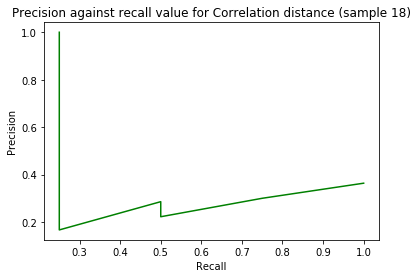

In [0]:
YX = correlation_map[33].values()
X, Y = [], []
for yx in YX:
  X.append(yx[1])
  Y.append(yx[0])
plt.title("Precision against recall value for Correlation distance (sample 18)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(X, Y, 'g')
plt.show()

In [0]:
# mAP numerical values
print('Manhattan: {}'.format(manhattan_map_value))
print('Manhattan normalised: {}'.format(manhattan_n_map_value))
print('')
print('Euclidean: {}'.format(euclidean_map_value))
print('Euclidean normalised: {}'.format(euclidean_n_map_value))
print('')
print('Chebyshev: {}'.format(chebyshev_map_value))
print('Chebyshev normalised: {}'.format(chebyshev_n_map_value))
print('')
print('Chi squared: {}'.format(chi_map_value))
print('Chi squared normalised: {}'.format(chi_n_map_value))
print('')
print('Cosine: {}'.format(cosine_map_value))
print('Cosine normalised: {}'.format(cosine_n_map_value))
print('')
print('Correlation: {}'.format(correlation_map_value))
print('Correlation normalised: {}'.format(correlation_n_map_value))

### Experiment 1

Implement histogram of pixel intensities as the feature representa- tions (consider different ways of choosing bins or quantities different than pixel intensities) and use standard non-learned distance metrics discussed in the lecture to evaluate the performance.

In [0]:
def histogram(img, bins):
  hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
  # hist = cv2.normalize(hist, hist).flatten()
  return hist.flatten()

def histogramDistance(H1, histograms, method, y=y_test):
  distance = []
  for H2, label in zip(histograms, y):
    distance.append((cv2.compareHist(H1, H2, method), label))
  return distance

In [0]:
# calculate histogram images
hist_test = []
for img in X_test:
  hist_test.append(histogram(img, bins=50))
hist_test = np.array(hist_test)

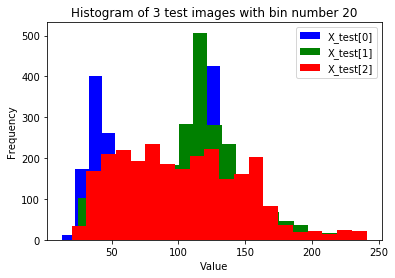

In [0]:
# plot histogram
color = ('b','g','r')
leyenda = ('X_test[0]', 'X_test[1]', 'X_test[2]')
for img,col in zip(X_test[:3], color):
    # histr = cv2.calcHist([img],[0],None,[256],[0,256])
    # histr = cv2.normalize(histr, histr).flatten()
    num_bins = 20
    plt.hist([img], num_bins, color = col)
    # plt.xlim([0,256])
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 3 test images with bin number {}'.format(num_bins))
plt.legend(leyenda)
plt.show()

In [0]:
# CALCULATE DISTANCES
bhattacharyya_hist_matrix = []
intersection_hist_matrix = []
chi_sq_hist_matrix = []
correlation_hist_matrix = []

for H1 in hist_test:
  # intersection distance
  intersection_hist_matrix.append(histogramDistance(H1, hist_test, cv2.HISTCMP_INTERSECT))
  # Bhattacharyya distance
  bhattacharyya_hist_matrix.append(histogramDistance(H1, hist_test, cv2.HISTCMP_BHATTACHARYYA))
  # chi-square distance
  chi_sq_hist_matrix.append(histogramDistance(H1, hist_test, cv2.HISTCMP_CHISQR))
  # correlation distance
  correlation_hist_matrix.append(histogramDistance(H1, hist_test, cv2.HISTCMP_CORREL))

# ORDER DISTANCES
ordered_bhattacharyya_hist_matrix = []
ordered_intersection_hist_matrix = []
ordered_chi_sq_hist_matrix = []
ordered_correlation_hist_matrix = []

# original
for bha, inter, chi, cor in zip(bhattacharyya_hist_matrix, intersection_hist_matrix, chi_sq_hist_matrix, correlation_hist_matrix):
  ordered_bhattacharyya_hist_matrix.append(sorted(bha))
  ordered_intersection_hist_matrix.append(sorted(inter))
  ordered_chi_sq_hist_matrix.append(sorted(chi))
  ordered_correlation_hist_matrix.append(sorted(cor))


In [0]:
# Calculate HIST rank1 and rank10 

intersection_hist_rank1, intersection_hist_rank10 = calculateRank(ordered_intersection_hist_matrix)
bhattacharyya_hist_rank1, bhattacharyya_hist_rank10 = calculateRank(ordered_bhattacharyya_hist_matrix)
chi_hist_rank1, chi_hist_rank10 = calculateRank(ordered_chi_sq_hist_matrix)
correlation_hist_rank1, correlation_hist_rank10 = calculateRank(ordered_correlation_hist_matrix)

print("Intersection: rank1 = {:.2f} rank10 = {:.2f}".format(intersection_hist_rank1, intersection_hist_rank10))
print('')
print("Bhattacharyya: rank1 = {:.2f} rank10 = {:.2f}".format(bhattacharyya_hist_rank1, bhattacharyya_hist_rank10))
print('')
print("Chi squared: rank1 = {:.2f} rank10 = {:.2f}".format(chi_hist_rank1, chi_hist_rank10))
print('')
print("Correlation: rank1 = {:.2f} rank10 = {:.2f}".format(correlation_hist_rank1, correlation_hist_rank10))

In [0]:
# Draw mAP

bhattacharyya_hist_map = calculateMAP(ordered_bhattacharyya_hist_matrix)
intersection_hist_map = calculateMAP(ordered_intersection_hist_matrix)
chi_hist_map = calculateMAP(ordered_chi_sq_hist_matrix)
correlation_hist_map = calculateMAP(ordered_correlation_hist_matrix)

# Calculate numerical mAP
bhattacharyya_hist_map_value = numericalMAP(bhattacharyya_hist_map)
intersection_hist_map_value = numericalMAP(intersection_hist_map)
chi_hist_map_value = numericalMAP(chi_hist_map)
correlation_hist_map_value = numericalMAP(correlation_hist_map)

# mAP numerical values
print('Bhattacharyya: {}'.format(bhattacharyya_hist_map_value))
print('')
print('Intersection: {}'.format(intersection_hist_map_value))
print('')
print('Chi squared: {}'.format(chi_hist_map_value))
print('')
print('Correlation: {}'.format(correlation_hist_map_value))

### Experiment 2

Implement Mahalanobis distance metric by calculating covariance matrix on the training split of features in A and report the performance by applying it to the test split. Use it to reduce the dimensionality to {16,32,64,128,256}

In [0]:
def normalise(matrix):
  mm = []
  for m in matrix:
    mm.append(np.real(m))
  mat = np.array(mm)

  return normalize(mat, axis=0, norm='l1')

In [0]:
N, px = X_train.shape
# average faces
mean = np.zeros(px)
for face in X_train:
  mean += face
  
mean = 1/N*mean

In [0]:
A = [X_train[i] - mean for i in range(N)]
A = np.array(A)
A = A.T
S_A = 1/N*A.dot(A.T)

In [0]:
# normalise the face
face_avg = np.array(mean).reshape(2576, 1)
face_avg = normalize(face_avg, axis=0, norm='l1')
mean_N = np.concatenate(face_avg.T)

In [0]:
# Eigenvectors
og_eval, og_evec = np.linalg.eig(S_A)

In [0]:
dimensions = 256

evecs = og_evec.T[:dimensions]
evals = np.real(og_eval.T[:dimensions])

evec_N = normalise(evecs)

In [0]:
w = A.T.dot(evec_N.T)

In [0]:
def decomposition(evals, evecs, dimensionality):
  evals_sqr = np.array([sqrt(eigen_val) for eigen_val in evals])
  diagonal = np.diag(evals_sqr)
  G = diagonal.dot(evecs)
  return G

def mahalanobis(u, X, G, y=y_test, normalised=False):
  mahalanobis = []
  for img, label in zip(X, y):
      mahalanobis.append((ssd.euclidean(G.dot(img), G.dot(u)), label))
  return mahalanobis

In [0]:
mahalanobis_matrix, mahalanobis_matrix_N = [], []

G = decomposition(evals, evecs, dimensionality=256) 

for x, xn in zip(X_test, X_test_N):
  # mahalanobis distance
  mahalanobis_matrix.append(mahalanobis(x, X_test, G))
  mahalanobis_matrix_N.append(mahalanobis(xn, X_test_N, G))

In [0]:
ordered_mah, ordered_mah_N = [], []
for mah, mah_n in zip(mahalanobis_matrix, mahalanobis_matrix_N):
  ordered_mah.append(sorted(mah))
  ordered_mah_N.append(sorted(mah_n))

mahalanobis_rank1, mahalanobis_rank10 = calculateRank(ordered_mah)
mahalanobis_N_rank1, mahalanobis_N_rank10 = calculateRank(ordered_mah_N)

print(mahalanobis_rank1, mahalanobis_rank10)
print(mahalanobis_N_rank1, mahalanobis_N_rank10)